# [0.1] - Ray Tracing (exercises)

> **ARENA [Streamlit Page](https://arena-chapter0-fundamentals.streamlit.app/01_[0.1]_Ray_Tracing)**
>
> **Colab: [exercises](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter0_fundamentals/exercises/part1_ray_tracing/0.1_Ray_Tracing_exercises.ipynb?t=20250209) | [solutions](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter0_fundamentals/exercises/part1_ray_tracing/0.1_Ray_Tracing_solutions.ipynb?t=20250209)**

Please send any problems / bugs on the `#errata` channel in the [Slack group](https://join.slack.com/t/arena-uk/shared_invite/zt-2zick19fl-6GY1yoGaoUozyM3wObwmnQ), and ask any questions on the dedicated channels for this chapter of material.

You can collapse each section so only the headers are visible, by clicking the arrow symbol on the left hand side of the markdown header cells.

Links to all other chapters: [(0) Fundamentals](https://arena-chapter0-fundamentals.streamlit.app/), [(1) Transformer Interpretability](https://arena-chapter1-transformer-interp.streamlit.app/), [(2) RL](https://arena-chapter2-rl.streamlit.app/).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/headers/header-01.png" width="350">

# Introduction

Today we'll be practicing batched matrix operations in PyTorch by writing a basic graphics renderer. We'll start with an extremely simplified case and work up to rendering your very own 3D Pikachu!

We'll also be touching on some general topics which will be important going forwards in this course, such as:

* Using GPT systems to assist your learning and coding
* Typechecking, and good coding practices
* Debugging, with VSCode's built-in run & debug features

## Content & Learning Objectives

### 1️⃣ Rays & Segments

This section introduces the key ideas and concepts in today's exercises, and guides you through some basic functions involving creating & using 2D rays.

> ##### Learning Objectives
>
> - Learn how to create PyTorch tensors in a variety of ways
> - Understand how to parametrize lines and rays in 2D
> - Learn about type annotations and linear operations in PyTorch

### 2️⃣ Batched Operations

In the next section, you'll extend your work from the first section to perform batched operations, i.e. operations over several different dimensions at once.

> ##### Learning Objectives
>
> - Learn about some important concepts related to batched operations, e.g. broadcasting and logical reductions
> - Understand and use the `einops` library
> - Apply this knowledge to create & work with a batch of rays

### 3️⃣ Triangles

In the final section we move into the 2D and 3D realms, and build up to rendering a full 3D mesh as a 2D image.

> ##### Learning Objectives
>
> - Understand how to parametrize triangles in 2D and 3D, and solve for their intersection with rays
> - Put everything together, to render your mesh as a 2D image

### 4️⃣ Video & Lighting

In the last set of exercises, you can implement some more mathematically complex forms of raytracing to get things like dynamic lighting & videos. There's also some optional material at the very end which covers the `pytest` library, and has you write your own tests.

> ##### Learning Objectives
>
> - Learn how surface normal vectors can be used to compute lighting effects
> - Render your figures in video form (as an animated camera pan)
> - (optional) Learn about the `pytest` library, and write your own tests for the functions you wrote

## Setup code

In [2]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter0_fundamentals"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import jaxtyping
except:
    %pip install jaxtyping einops

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 1.7 MB/s eta 0:00:00
--2025-03-07 04:00:22--  https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/callummcdougall/ARENA_3.0/zip/refs/heads/main [following]
--2025-03-07 04:00:22--  https://codeload.github.com/callummcdougall/ARENA_3.0/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/main.zip’

main.zip                [          <=>       ]  20.96M  9.25MB/s    in 2.3s    

2025-03-07 04:00:25 (9.25 MB/s) - ‘/content/main.zip’ saved [21977856]

Archive:  /content/main.zip
4e4

In [3]:
import os
import sys
from functools import partial
from pathlib import Path
from typing import Any, Callable

import einops
import plotly.express as px
import plotly.graph_objects as go
import torch as t
from IPython.display import display
from ipywidgets import interact
from jaxtyping import Bool, Float
from torch import Tensor
from tqdm import tqdm

# Make sure exercises are in the path
chapter = "chapter0_fundamentals"
section = "part1_ray_tracing"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section
if str(exercises_dir) not in sys.path:
    sys.path.append(str(exercises_dir))

import part1_ray_tracing.tests as tests
from part1_ray_tracing.utils import render_lines_with_plotly, setup_widget_fig_ray, setup_widget_fig_triangle
from plotly_utils import imshow

MAIN = __name__ == "__main__"

<details>
<summary>Help - I get a NumPy-related error</summary>

This is an annoying colab-related issue which I haven't been able to find a satisfying fix for. If you restart runtime (but don't delete runtime), and run just the imports cell above again (but not the `%pip install` cell), the problem should go away.
</details>


<details>
<summary>Note on <code>pathlib</code></summary>

We'll be using the `pathlib` library to define file paths. This is a more modern way of working with file paths than the `os` library, and is more cross-platform. You can read more about it [here](https://realpython.com/python-pathlib/).

A major advantage of using `pathlib` rather than just relative path names is that it is more robust to which file / directory you happen to be running your code in. There's nothing more frustrating than failing to import or load a file, even though you can see it right there in your directory! Most of our code to load files will look something like this:

```python
with open(section_dir / "pikachu.pt", "rb") as f:
    triangles = t.load(f)
```

since `section_dir` is the name of the `part1_ray_tracing` directory, and forward slashes are used to define files or directories within that directory.
</details>

# 1️⃣ Rays & Segments

> ##### Learning Objectives
>
> - Learn how to create PyTorch tensors in a variety of ways
> - Understand how to parametrize lines and rays in 2D
> - Learn about type annotations and linear operations in PyTorch

## 1D Image Rendering

In our initial setup, the **camera** will be a single point at the origin, and the **screen** will be the plane at x=1.

**Objects** in the world consist of triangles, where triangles are represented as 3 points in 3D space (so 9 floating point values per triangle). You can build any shape out of sufficiently many triangles and your Pikachu will be made from 412 triangles.

The camera will emit one or more **rays**, where a ray is represented by an **origin** point and a **direction** point. Conceptually, the ray is emitted from the origin and continues in the given direction until it intersects an object.

We have no concept of lighting or color yet, so for now we'll say that a pixel on our screen should show a bright color if a ray from the origin through it intersects an object, otherwise our screen should be dark.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ray_tracing.png" width="400">

To start, we'll let the z dimension in our `(x, y, z)` space be zero and work in the remaining two dimensions.

### Exercise - implement `make_rays_1d`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Implement the following `make_rays_1d` function so it generates some rays coming out of the origin, which we'll take to be `(0, 0, 0)`.

Calling `render_lines_with_plotly` on your rays will display them in a 3D plot.

In [ ]:
def make_rays_1d(num_pixels: int, y_limit: float) -> Tensor:
    """
    num_pixels: The number of pixels in the y dimension. Since there is one ray per pixel, this is also the number of rays.
    y_limit: At x=1, the rays should extend from -y_limit to +y_limit, inclusive of both endpoints.

    Returns: shape (num_pixels, num_points=2, num_dim=3) where the num_points dimension contains (origin, direction) and the num_dim dimension contains xyz.

    Example of make_rays_1d(9, 1.0): [
        [[0, 0, 0], [1, -1.0, 0]],
        [[0, 0, 0], [1, -0.75, 0]],
        [[0, 0, 0], [1, -0.5, 0]],
        ...
        [[0, 0, 0], [1, 0.75, 0]],
        [[0, 0, 0], [1, 1, 0]],
    ]
    """

    increment = 0
    rays=[]
    for num in range(num_pixels):
      y = y_limit - increment
      rays.append([[0,0,0],[1,y, 0]])
      increment += (2 * y_limit) /num_pixels;
    return t.tensor(rays, dtype=t.float32)



    # raise NotImplementedError()


rays1d = make_rays_1d(9, 10.0)
fig = render_lines_with_plotly(rays1d)

<details><summary>Solution</summary>

```python
def make_rays_1d(num_pixels: int, y_limit: float) -> Tensor:
    """
    num_pixels: The number of pixels in the y dimension. Since there is one ray per pixel, this is also the number of rays.
    y_limit: At x=1, the rays should extend from -y_limit to +y_limit, inclusive of both endpoints.

    Returns: shape (num_pixels, num_points=2, num_dim=3) where the num_points dimension contains (origin, direction) and the num_dim dimension contains xyz.

    Example of make_rays_1d(9, 1.0): [
        [[0, 0, 0], [1, -1.0, 0]],
        [[0, 0, 0], [1, -0.75, 0]],
        [[0, 0, 0], [1, -0.5, 0]],
        ...
        [[0, 0, 0], [1, 0.75, 0]],
        [[0, 0, 0], [1, 1, 0]],
    ]
    """
    rays = t.zeros((num_pixels, 2, 3), dtype=t.float32)
    t.linspace(-y_limit, y_limit, num_pixels, out=rays[:, 1, 1])
    rays[:, 1, 0] = 1
    return rays
```
</details>

In [ ]:
rays = t.tensor([[[0, 0, 0], [1, -1.0, 0]],
        [[0, 0, 0], [1, -0.75, 0]]])
rays[:, 1, 1]

tensor([-1.0000, -0.7500])

### Tip - the `out` keyword argument

Many PyTorch functions take an optional keyword argument `out`. If provided, instead of allocating a new tensor and returning that, the output is written directly to the `out` tensor.

If you used `torch.arange` or `torch.linspace` above, try using the `out` argument. Note that a basic indexing expression like `rays[:, 1, 1]` returns a view that shares storage with `rays`, so writing to the view will modify `rays`. You'll learn more about views later today.

## Ray-Object Intersection

Suppose we have a line segment defined by points $L_1$ and $L_2$. Then for a given ray, we can test if the ray intersects the line segment like so:

- Supposing both the ray and line segment were infinitely long, solve for their intersection point.
- If the point exists, check whether that point is inside the line segment and the ray.

Our camera ray is defined by the origin $O$ and direction $D$ and our object line is defined by points $L_1$ and $L_2$.

We can write the equations for all points on the camera ray as $R(v)=O +v D$ for $v \in [0, \infty)$ and on the object line as $O(v)=L_1+v(L_2 - L_1)$ for $v \in [0, 1]$.

The following interactive widget lets you play with this parameterization of the problem. Run the cells one after another:

In [ ]:
fig: go.FigureWidget = setup_widget_fig_ray()
display(fig)


@interact(v=(0.0, 6.0, 0.01), seed=list(range(10)))
def update(v=0.0, seed=0):
    t.manual_seed(seed)
    L_1, L_2 = t.rand(2, 2)
    P = lambda v: L_1 + v * (L_2 - L_1)
    x, y = zip(P(0), P(6))
    with fig.batch_update():
        fig.update_traces({"x": x, "y": y}, 0)
        fig.update_traces({"x": [L_1[0], L_2[0]], "y": [L_1[1], L_2[1]]}, 1)
        fig.update_traces({"x": [P(v)[0]], "y": [P(v)[1]]}, 2)

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '999efce1-388c-44ff-8ed9-df8920929091', 'x': [], 'y': []},
             {'marker': {'size': 12},
              'mode': 'markers',
              'name': 'v=0',
              'type': 'scatter',
              'uid': 'cd644589-6d7b-41ae-b1b8-2e6fc0e2071e',
              'x': [],
              'y': []},
             {'marker': {'size': 12, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'v=1',
              'type': 'scatter',
              'uid': '99e810f8-7290-4baf-a835-9fcba1d7bc95',
              'x': [],
              'y': []}],
    'layout': {'height': 400,
               'margin': {'b': 10, 'l': 40, 't': 60},
               'showlegend': False,
               'template': '...',
               'title': {'text': 'Ray coordinates illustration'},
               'width': 500,
               'xaxis': {'range': [-1.5, 2.5]},
               'yaxis': {'range': [-1.5, 2.5]}}
})

interactive(children=(FloatSlider(value=0.0, description='v', max=6.0, step=0.01), Dropdown(description='seed'…

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

Setting the line equations from above equal gives the solution:

$$
\begin{aligned}O + u D &= L_1 + v(L_2 - L_1) \\ u D - v(L_2 - L_1) &= L_1 - O  \\ \begin{pmatrix} D_x & (L_1 - L_2)_x \\ D_y & (L_1 - L_2)_y \\ \end{pmatrix} \begin{pmatrix} u \\ v \\ \end{pmatrix} &=  \begin{pmatrix} (L_1 - O)_x \\ (L_1 - O)_y \\ \end{pmatrix} \end{aligned}
$$

Once we've found values of $u$ and $v$ which satisfy this equation, if any (the lines could be parallel) we just need to check that $u \geq 0$ and $v \in [0, 1]$.

### Exercise - implement `intersect_ray_1d`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 20-25 minutes on this exercise.
> It involves some of today's core concepts - tensor manipulation, linear operations, etc.
> ```

Using [`torch.linalg.solve`](https://pytorch.org/docs/stable/generated/torch.linalg.solve.html) and [`torch.stack`](https://pytorch.org/docs/stable/generated/torch.stack.html), implement the `intersect_ray_1d` function to solve the above matrix equation.

<details>
<summary>Aside - difference between stack and concatenate</summary>

`torch.stack` will combine tensors along a new dimension.

```python
>>> t.stack([t.ones(2, 2), t.zeros(2, 2)], dim=0)
tensor([[[1., 1.],
         [1., 1.]],

        [[0., 0.],
         [0., 0.]]])
```

`torch.concat` (alias `torch.cat`) will combine tensors along an existing dimension.

```python
>>> t.cat([t.ones(2, 2), t.zeros(2, 2)], dim=0)
tensor([[1., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.]])
```

Here, you should use `torch.stack` to construct e.g. the matrix on the left hand side, because you want to combine the vectors $D$ and $L_1 - L_2$ to make a matrix.
</details>

Is it possible for the solve method to fail? Give a sample input where this would happen.

<details>
<summary>Answer - Failing Solve</summary>

If the ray and segment are exactly parallel, then the solve will fail because there is no solution to the system of equations. For this function, handle this by catching the exception and returning False.
</details>

In [ ]:
d = t.tensor([1,2,3])
l1 = t.tensor([4,4,4])
l2 = t.tensor([6,6,6])
t.stack((d, (l1-l2)), dim = 1)


tensor([[ 1, -2],
        [ 2, -2],
        [ 3, -2]])

In [ ]:
einops.einsum(t.stack((d, - (l2 - l1))), 'i j -> j i')

tensor([[ 1, -2],
        [ 2, -2],
        [ 3, -2]])

Setting the line equations from above equal gives the solution:

$$
\begin{aligned}O + u D &= L_1 + v(L_2 - L_1) \\ u D - v(L_2 - L_1) &= L_1 - O  \\ \begin{pmatrix} D_x & (L_1 - L_2)_x \\ D_y & (L_1 - L_2)_y \\ \end{pmatrix} \begin{pmatrix} u \\ v \\ \end{pmatrix} &=  \begin{pmatrix} (L_1 - O)_x \\ (L_1 - O)_y \\ \end{pmatrix} \end{aligned}
$$

Once we've found values of $u$ and $v$ which satisfy this equation, if any (the lines could be parallel) we just need to check that $u \geq 0$ and $v \in [0, 1]$.

In [ ]:
def intersect_ray_1d(ray: Float[Tensor, "points dims"], segment: Float[Tensor, "points dims"]) -> bool:
    """
    ray: shape (n_points=2, n_dim=3)  # O, D points
    segment: shape (n_points=2, n_dim=3)  # L_1, L_2 points

    Return True if the ray intersects the segment.
    """
    line = segment[1] - segment[0]
    crossProduct = t.cross(line, ray[1])
    if t.all(crossProduct == 0):
      return False
    try:
      RHS = segment[0] - ray[0]
      LHS = einops.einsum(t.stack((ray[1], - (segment[1] - segment[0]))), 'i j -> j i')
      # LHS = t.stack((d, (l2-l1)), dim = 1)
      solution = t.linalg.lstsq(LHS, RHS).solution
      u_value, v_value = solution.tolist()
      # u must be positive so the intersection is in front of O, and u must be between 0 and 1 so the intersection is wihtin segment
      return u_value >= 0 and 0 <= v_value <= 1
    except RuntimeError:
      return False


    # raise NotImplementedError()


tests.test_intersect_ray_1d(intersect_ray_1d)
tests.test_intersect_ray_1d_special_case(intersect_ray_1d)

All tests in `test_intersect_ray_1d` passed!
All tests in `test_intersect_ray_1d_special_case` passed!


<details>
<summary>Help! My code is failing with a 'must be batches of square matrices' exception.</summary>

Our formula only uses the x and y coordinates - remember to discard the z coordinate for now.

It's good practice to write asserts on the shape of things so that your asserts will fail with a helpful error message. In this case, you could assert that the `mat` argument is of shape (2, 2) and the `vec` argument is of shape (2,). Also, see the aside below on typechecking.
</details>


<details><summary>Solution</summary>

```python
def intersect_ray_1d(ray: Float[Tensor, "points dims"], segment: Float[Tensor, "points dims"]) -> bool:
    """
    ray: shape (n_points=2, n_dim=3)  # O, D points
    segment: shape (n_points=2, n_dim=3)  # L_1, L_2 points

    Return True if the ray intersects the segment.
    """
    # Get the x and y coordinates (ignore z)
    ray = ray[:, :2]
    segment = segment[:, :2]

    # Ray is [[Ox, Oy], [Dx, Dy]]
    O, D = ray
    # Segment is [[L1x, L1y], [L2x, L2y]]
    L_1, L_2 = segment

    # Create matrix and vector, and solve equation
    mat = t.stack([D, L_1 - L_2], dim=-1)
    vec = L_1 - O

    # Solve equation (return False if no solution)
    try:
        sol = t.linalg.solve(mat, vec)
    except RuntimeError:
        return False

    # If there is a solution, check the soln is in the correct range for there to be an intersection
    u = sol[0].item()
    v = sol[1].item()
    return (u >= 0.0) and (v >= 0.0) and (v <= 1.0)
```
</details>

### Aside - type hints

Adding type hints to your code is a useful habit to get into. Some advantages of using them:

- **They help document your code**, making it more readable (for yourself and for others)
- **The improve IDE behaviour**, i.e. getting better code completion
- **They encourage better code structure**, since they force you to consider your inputs & outputs explicitly
- **They make debugging easier**, since you'll find it easier to spot where a variable might not match the type signature you've given for it

As well as simple objects, you can also typecheck iterables of objects, for example:

- `list[int]` for a list of integers,
- `dict[str, float]` for a dict mapping strings to floats,
- `tuple[Tensor, Tensor]` for a length-2 tuple containing tensors,
- `tuple[int, ...]` for a tuple containing one or more integers.

and you can also use other syntax to extend behaviour, e.g. `x: int | None` for a variable which can either be an integer or `None`.

Jaxtyping also gives us useful type hint features, e.g. we have `ray: Float[Tensor, "points dims"]` to indicate a tensor of floats with dimensions `points` and `dims`. Unlike the examples above this is unlikely to be captured by syntax highlighting when you make a mistake, instead it's best to view this as an alternative to annotating the tensor shape. You may or may not prefer to use this.

When in doubt however, it's best to make assertions on the variable type or tensor shape explicitly, e.g. `assert isinstance(x, Tensor)` or `assert x.shape == ...`. We generally don't recommend static type checking like [mypy](https://mypy-lang.org/) in this course, because there aren't generally standard and robust ways to do it which will fit all IDEs & use-cases.

# 2️⃣ Batched Operations

> ##### Learning Objectives
>
> - Learn about some important concepts related to batched operations, e.g. broadcasting and logical reductions
> - Understand and use the `einops` library
> - Apply this knowledge to create & work with a batch of rays

In this section, we'll move onto batched operations. First, it's necessary to cover some important tips for working effectively with PyTorch tensors. If you've gone through the prerequisite material then several of these should already be familiar to you.

## Tensor Operations - 5 Tips

### Tip (1/5) - Elementwise Logical Operations on Tensors

For regular booleans, the keywords `and`, `or`, and `not` are used to do logical operations and the operators `&`, `|`, and `~` do and, or and not on each bit of the input numbers. Analogously, we use the operators `&`, `|` `~` on tensors to perform these operations on each element of the tensor, e.g. `x & y` returns the tensor with elements `x[i] and y[i]`.

A few important gotchas here:

- Don't try to use `and`, `or` or `not` on tensors, since Python will try to coerce the tensors to booleans, and you'll get an exception.
- Remember about **operator precedence**! For instance, `v >= 0 & v <= 1` will actually throw an error because it's evaluated as actually evaluated as `(v >= (0 & v)) <= 1` (because `&` has high precedence) and `0 & v` is not a valid operation. When in doubt, use parentheses to force the correct parsing: `(v >= 0) & (v <= 1)`.

### Tip (2/5) - `einops`

* Einops is a useful library which we'll dive deeper with tomorrow.
* For now, the only important function you'll need to know is `einops.repeat`.
* This takes as arguments a tensor and a string, and returns a new tensor which has been repeated along the specified dimensions.
* For example, the following code shows how we can repeat a 2D tensor along the last dimension:

```python
x = t.randn(4, 3)
x_repeated = einops.repeat(x, 'a b -> a b c', c=2) # copies x along a new dimension at the end

assert x_repeated.shape == (4, 3, 2)
t.testing.assert_close(x_repeated[:, :, 0], x)
t.testing.assert_close(x_repeated[:, :, 1], x)
```

### Tip (3/5) - Logical Reductions

* In plain Python, if you have a list of lists and want to know if any element in a row is `True`, you could use a list comprehension like `[any(row) for row in rows]`.
* The efficient way to do this in PyTorch is with `torch.any()` or equivalently the `.any()` method of a tensor, which accept the dimension to reduce over. Similarly, `torch.all()` or `.all()` method.
* Both of these methods accept a `dim` argument, which is the dimension to reduce over.

<details>
<summary>Aside - tensor methods</summary>

Most functions like `torch.any(tensor, ...)` (which take a tensor as first argument) have an equivalent tensor method `tensor.any(...)`. We'll see many more examples of functions like this as we go through the course.
</details>

### Tip (4/5) - Broadcasting

* Broadcasting is what happens when you perform an operation on two tensors, and one is a smaller size, but is copied along the dimensions of the larger one in order to apply to it.
* There are some complicated broadcasting rules which we'll get into later in the course (you can also review the broadcasting section in the prerequisite material which comes before this chapter), but for our purposes the only thing you need to know is this:
* if you perform an operation on 2 tensors `A, B` where `A.shape == B.shape[-A.ndim:]` (i.e. `A` matches the last dimensions of `B`), then `A` will be copied along its leading dimensions until it has the same shape as `B`.

For example:

```python
B = t.ones(4, 3, 2)
A = t.ones(3, 2)
C = A + B
print(C.shape) # torch.Size([4, 3, 2]), the size of the broadcasted tensor
print(C.max(), C.min()) # tensor(2.) tensor(2.), because all elements are 2
```

### Tip (5/5) - Indexing

Indexing is a pretty deep topic in PyTorch, and it takes a while to get fully comfortable with it. However, we'll specifically cover some features which will be useful for the following exercises.

**Using ellipses.** You can use an ellipsis `...` in an indexing expression to avoid repeated `:` and to write indexing expressions that work on varying numbers of input dimensions. For example, `x[..., 0]` is equivalent to `x[:, :, 0]` if `x` is 3D, and equivalent to `x[:, :, :, 0]` if `x` is 4D.

**Boolean indexing.** Boolean indexing allows you to select elements of a tensor based on a corresponding boolean tensor. Only the elements where the boolean value is True are selected. The following example shows boolean indexing *and* broadcasting:

```python
D = t.ones(2)  # Tensor with shape (2,)
E = t.zeros(3, 2)  # Tensor with shape (3, 2)
E[[True, False, True], :].shape  # Shape: (2, 2)
E[[True, False, True], :] = D  # Assign values from D to selected rows
print(E)
# output:
# tensor([[1., 1.],
#         [0., 0.],
#         [1., 1.]])
```

Note that `E` gets modified when `E[[True, False, True], :]` gets modified - this is because the latter is a **view** of the former, not a new tensor (i.e. it points to the same place in memory) - we'll look a bit more at this topic later.

**Multi-dimensional indexing.** You can also apply boolean indexing to multiple dimensions simultaneously. This allows you to select elements across several dimensions based on a boolean condition. The following example shows multi-dimensional boolean indexing *and* broadcasting:

```python
D = t.ones(2)  # Tensor with shape (2,)
F = t.zeros(2, 2, 2)  # Tensor with shape (2, 2, 2)
F[[[True, True], [False, True]], :].shape  # Shape: (3, 2)
F[[[True, True], [False, True]], :] = D
print(F)
# output:
# tensor([[[1., 1.],
#          [1., 1.]],

#         [[0., 0.],
#          [1., 1.]]])
```

This works because our indexing creates a tensor of shape `(3, 2)`, formed by stacking the three tensors `F[0, 0]`, `F[0, 1]` and `F[1, 1]` (those where the corresponding index value is True) along a new leading dimension.

### Summary of tips

> * Use `...` to avoid repeated `:` in indexing expressions
> * Use `&`, `|`, and `~` for elementwise logical operations on tensors
> * Use parentheses to force the correct operator precedence
> * Use `torch.any()` or `.any()` to do logical reductions (you can do this over a single dimension, with the `dim` argument)
> * Tensors can broadcast along leading dimensions to operate together
>   * e.g. `t.ones(2) + t.ones(3, 2)` works because the former tensor gets broadcasted to shape `(3, 2)`
> * We can index with boolean tensors to select multiple elements
>   * e.g. if `A.shape = (3, n1, n2, ...)` then `A[[True, False, True]]` has shape `(2, n1, n2, ...)` and contains the first & third rows of `A`
> * We can index with multi-dimensional boolean tensors too
>   * e.g. if `A.shape = (2, 2, n1, n2, ...)` then `A[[[True, True], [False, True]], :]` has shape `(3, n1, n2, ...)` and contains the elements `A[0, 0]`, `A[0, 1]` and `A[1, 1]`, stacked along a new leading dimension

## Batched Ray-Segment Intersection

We'll now move on to implementing a batched version of our previous function which takes multiple rays, multiple line segments, and returns a boolean for each ray indicating whether ***any*** segment intersects with that ray.

Note - in the batched version, we don't want the solver to throw an exception just because some of the equations don't have a solution - these should just return False.

### Exercise - implement `intersect_rays_1d`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 25-40 minutes on this exercise.
> This will probably be one of the hardest exercises you'll complete today.
> ```

One part you might find difficult is dealing with the zero determinant cases. Previously we dealt with those by using `try / except`, but here we can't do that because we want to perform all the operations at once. Instead, we can use the following clever trick to find all the pairs of intersecting rays and segments:

1. Figure out which matrices have zero determinant (e.g. with `determinants.abs() < 1e-8`)
2. Replace those matrices with the identity matrix `t.eye(2)`, since this will certainly not raise an error when solving
3. Find the matrices s.t. `u, v` are in the required range **and** our original matrix was non-singular

This way, we've identified all pairs of rays and segments where an intersection point exists **and** that intersection point is valid (i.e. it's actually on the positive side of the ray, and somewhere in the middle of the segment).

Once we have this 2D array of booleans representing whether each ray intersects with each segment, we can reduce using the torch function `t.all` to find the rays which intersect *any* segment.

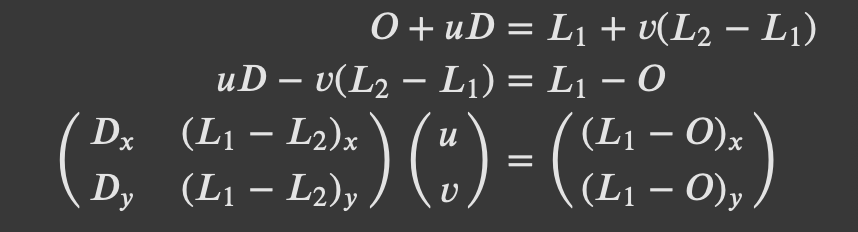

In [11]:
def intersect_rays_1d(
    rays: Float[Tensor, "nrays 2 3"], segments: Float[Tensor, "nsegments 2 3"]
) -> Bool[Tensor, "nrays"]:
    """
    For each ray, return True if it intersects any segment.
    """
    NR = rays.size(0)
    NS = segments.size(0)

    # Get just the x and y coordinates
    rays = rays[..., :2]
    segments = segments[..., :2]

    # Repeat rays and segments so that we can compuate the intersection of every (ray, segment) pair
    rays = einops.repeat(rays, "nrays p d -> nrays nsegments p d", nsegments=NS)
    segments = einops.repeat(segments, "nsegments p d -> nrays nsegments p d", nrays=NR)

    # Each element of `rays` is [[Ox, Oy], [Dx, Dy]]
    O = rays[:, :, 0]
    D = rays[:, :, 1]
    assert O.shape == (NR, NS, 2)

    # Each element of `segments` is [[L1x, L1y], [L2x, L2y]]
    L_1 = segments[:, :, 0]
    L_2 = segments[:, :, 1]
    assert L_1.shape == (NR, NS, 2)

    # Define matrix on left hand side of equation
    mat = t.stack([D, L_1 - L_2], dim=-1)
    # Get boolean of where matrix is singular, and replace it with the identity in these positions
    dets = t.linalg.det(mat)
    is_singular = dets.abs() < 1e-8
    assert is_singular.shape == (NR, NS)
    mat[is_singular] = t.eye(2)

    # Define vector on the right hand side of equation
    vec = L_1 - O

    # Solve equation, get results
    sol = t.linalg.solve(mat, vec)
    u = sol[..., 0]
    v = sol[..., 1]

    # Return boolean of (matrix is nonsingular, and solution is in correct range implying intersection)
    return ((u >= 0) & (v >= 0) & (v <= 1) & ~is_singular).any(dim=-1)

    ## question: why does it matter if the original matrix was non-singular - if that matters... why can't we just drop them from both A
    ## cuz the return requires an answer for each ray




    # raise NotImplementedError()


tests.test_intersect_rays_1d(intersect_rays_1d)
tests.test_intersect_rays_1d_special_case(intersect_rays_1d)

All tests in `test_intersect_rays_1d` passed!
All tests in `test_intersect_rays_1d_special_case` passed!


<details>
<summary>Help - I don't know how to set all my matrices to the identity</summary>

You should have some variable `mat` which is a batch of matrices, i.e. it has shape `(n_rays, n_segments, 2, 2)`. You can then define `is_singular` as a boolean tensor of shape `(n_rays, n_segments)` which is true wherever the matrix is singular. Now, indexing `mat[is_singular]` returns a tensor of shape `(N, 2, 2)` where the `[i, :, :]`-th element is the `i`-th singular matrix. Thanks to broadcasting rules, you can set `mat[is_singular] = t.eye(2)`, and the identity matrix with shape `(2, 2)` will get broadcasted to the left hand shape `(N, 2, 2)`.

</details>


<details><summary>Solution</summary>

```python
def intersect_rays_1d(
    rays: Float[Tensor, "nrays 2 3"], segments: Float[Tensor, "nsegments 2 3"]
) -> Bool[Tensor, "nrays"]:
    """
    For each ray, return True if it intersects any segment.
    """
    NR = rays.size(0)
    NS = segments.size(0)

    # Get just the x and y coordinates
    rays = rays[..., :2]
    segments = segments[..., :2]

    # Repeat rays and segments so that we can compuate the intersection of every (ray, segment) pair
    rays = einops.repeat(rays, "nrays p d -> nrays nsegments p d", nsegments=NS)
    segments = einops.repeat(segments, "nsegments p d -> nrays nsegments p d", nrays=NR)

    # Each element of `rays` is [[Ox, Oy], [Dx, Dy]]
    O = rays[:, :, 0]
    D = rays[:, :, 1]
    assert O.shape == (NR, NS, 2)

    # Each element of `segments` is [[L1x, L1y], [L2x, L2y]]
    L_1 = segments[:, :, 0]
    L_2 = segments[:, :, 1]
    assert L_1.shape == (NR, NS, 2)

    # Define matrix on left hand side of equation
    mat = t.stack([D, L_1 - L_2], dim=-1)
    # Get boolean of where matrix is singular, and replace it with the identity in these positions
    dets = t.linalg.det(mat)
    is_singular = dets.abs() < 1e-8
    assert is_singular.shape == (NR, NS)
    mat[is_singular] = t.eye(2)

    # Define vector on the right hand side of equation
    vec = L_1 - O

    # Solve equation, get results
    sol = t.linalg.solve(mat, vec)
    u = sol[..., 0]
    v = sol[..., 1]

    # Return boolean of (matrix is nonsingular, and solution is in correct range implying intersection)
    return ((u >= 0) & (v >= 0) & (v <= 1) & ~is_singular).any(dim=-1)
```
</details>

## Using GPT to understand code

*Note, the world of LLMs moves fast, so this section is likely to get out of date at some point!*

Next week we'll start learning about transformers and how to build them, but it's not too early to start using them to accelerate your own learning!

We'll be discussing more advanced ways to use GPT 3 and 4 as coding partners / research assistants in the coming weeks, but for now we'll look at a simple example: **using GPT to understand code**. You're recommended to read the recent [LessWrong post](https://www.lesswrong.com/posts/ptY6X3BdW4kgqpZFo/using-gpt-4-to-understand-code) by Siddharth Hiregowdara in which he explains his process. This works best on GPT-4, but I've found GPT-3.5 works equally well for reasonably straightforward problems (see the section below).

Firstly, you should get an account to use GPT with if you haven't already. Next, try asking GPT-3.5 / 4 for an explanation of the function above. You can do this e.g. via the following prompt:

> Explain this Python function, line by line. You should break up your explanation by inserting sections of the code.
>
> ```python
> def intersect_rays_1d(rays: Float[Tensor, "nrays 2 3"], segments: Float[Tensor, "nsegments 2 3"]) -> Bool[Tensor, "nrays"]:
>     NR = rays.size(0)
>     NS = segments.size(0)
>     rays = rays[..., :2]
>     ...
> ```

I've found removing comments is often more helpful, because then GPT will answer in its own words rather than just repeating the comments (and the comments can sometimes confuse it).

Once you've got a response, here are a few more things you might want to consider asking:

* Can you suggest ways to improve the code?
    * GPT-4 recommended using a longer docstring and more descriptive variable names, among other things.
* Can you explain why the line `mat[is_singular] = t.eye(2)` works?
    * GPT-4 gave me a correct and very detailed explanation involving broadcasting and tensor shapes.

Is using GPT in this way cheating? It can be, if your first instinct is to jump to GPT rather than trying to understand the code yourself. But it's important here to bring up the distinction of [playing in easy mode](https://www.lesswrong.com/posts/nJPtHHq6L7MAMBvRK/play-in-easy-mode) vs [playing in hard mode](https://www.lesswrong.com/posts/7hLWZf6kFkduecH2g/play-in-hard-mode). There are situations where it's valuable for you to think about a problem for a while before moving forward because that deliberation will directly lead to you becoming a better researcher or engineer (e.g. when you're thinking of a hypothesis for how a circuit works while doing mechanistic interpretability on a transformer, or you're pondering which datastructure best fits your use case while implementing some RL algorithm). But there are also situations (like this one) where you'll get more value from speedrunning towards an understanding of certain code or concepts, and apply your understanding in subsequent exercises. It's important to find a balance!

#### When to use GPT-3.5 and GPT-4

GPT-3.5 and 4 both have advantages and disadvantages in different situations. GPT-3.5 has a large advantage in speed over GPT-4, and works equally well on simple problems or functions. If it's anything that Copilot is capable of writing, then you're likely better off using it instead of GPT-4.

On the other hand, GPT-4 has an advantage at generating coherent code (although we don't expect you to be using it for code generation much at this stage in the program), and is generally better at responding to complex tasks with less prompt engineering.

#### Additional notes on using GPT (from Joseph Bloom)

* ChatGPT is overly friendly. If you give it bad code it won't tell you it's shit so you need to encourage it to give feedback and/or show you examples of great code. Especially for beginner coders using it, it's important to realise how *under* critical it is.
* GPT is great at writing tests (asking it to write a test for a function is often better than asking it if a function is correct), refactoring code (identifying repeated tasks and extracting them) and naming variables well. These are specific things worth doing a few times to see how useful they can be.
* GPT-4 does well with whole modules/scripts so don't hesitate to add those. When you start managing repos on GitHub, use tracked files so that when you copy-paste edited code back, all the changes are highlighted for you as if you'd made them. (VSCode highlights changes with small blue bars next to the line numbers in your python files.)

Here are some things you can play around with:

* Ask GPT it to write tests for the function. You can give more specific instructions (e.g. asking it to use / not to use the `unittests` library, or to print more informative error messages).
* Ask GPT how to refactor the function above. (When I did this, it suggested splitting the function up into subfunctions which performed the discrete tasks of "compute intersection points")

## 2D Rays

Now we're going to make use of the z dimension and have rays emitted from the origin in both y and z dimensions.

### Exercise - implement `make_rays_2d`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 10-20 minutes on this exercise.
> ```

Implement `make_rays_2d` analogously to `make_rays_1d`. The result should look like a pyramid with the tip at the origin.

In [ ]:
def make_rays_2d(num_pixels_y: int, num_pixels_z: int, y_limit: float, z_limit: float) -> Float[Tensor, "nrays 2 3"]:
    """
    num_pixels_y: The number of pixels in the y dimension
    num_pixels_z: The number of pixels in the z dimension

    y_limit: At x=1, the rays should extend from -y_limit to +y_limit, inclusive of both.
    z_limit: At x=1, the rays should extend from -z_limit to +z_limit, inclusive of both.

    Returns: shape (num_rays=num_pixels_y * num_pixels_z, num_points=2, num_dims=3).
    """
    raise NotImplementedError()


rays_2d = make_rays_2d(10, 10, 0.3, 0.3)
render_lines_with_plotly(rays_2d)

<details>
<summary>Help - I'm not sure how to implement this function.</summary>

Don't write it as a function right away. The most efficient way is to write and test each line individually in the REPL to verify it does what you expect before proceeding.

You can either build up the output tensor using `torch.stack`, or you can initialize the output tensor to its final size and then assign to slices like `rays[:, 1, 1] = ...`. It's good practice to be able to do it both ways.

Each y coordinate needs a ray with each corresponding z coordinate - in other words this is an outer product. The most elegant way to do this is with two calls to `einops.repeat`. You can also accomplish this with `unsqueeze`, `expand`, and `reshape` combined.
</details>


<details><summary>Solution</summary>

```python
def make_rays_2d(num_pixels_y: int, num_pixels_z: int, y_limit: float, z_limit: float) -> Float[Tensor, "nrays 2 3"]:
    """
    num_pixels_y: The number of pixels in the y dimension
    num_pixels_z: The number of pixels in the z dimension

    y_limit: At x=1, the rays should extend from -y_limit to +y_limit, inclusive of both.
    z_limit: At x=1, the rays should extend from -z_limit to +z_limit, inclusive of both.

    Returns: shape (num_rays=num_pixels_y * num_pixels_z, num_points=2, num_dims=3).
    """
    n_pixels = num_pixels_y * num_pixels_z
    ygrid = t.linspace(-y_limit, y_limit, num_pixels_y)
    zgrid = t.linspace(-z_limit, z_limit, num_pixels_z)
    rays = t.zeros((n_pixels, 2, 3), dtype=t.float32)
    rays[:, 1, 0] = 1
    rays[:, 1, 1] = einops.repeat(ygrid, "y -> (y z)", z=num_pixels_z)
    rays[:, 1, 2] = einops.repeat(zgrid, "z -> (y z)", y=num_pixels_y)
    return rays
```
</details>

# 3️⃣ Triangles

> ##### Learning Objectives
>
> - Understand how to parametrize triangles in 2D and 3D, and solve for their intersection with rays
> - Put everything together, to render your mesh as a 2D image

## Triangle Coordinates

The area inside a triangle can be defined by three (non-collinear) points $A$, $B$ and $C$, and can be written algebraically as a **convex combination** of those three points:

$$
\begin{align*}
P(w, u, v) &= wA + uB + vC \quad\quad \\
    \\
s.t. \quad 0 &\leq w,u,v \\
1 &= w + u + v
\end{align*}
$$

Or equivalently:

$$
\begin{align*}
\quad\quad\quad\quad P(u, v) &= (1 - u - v)A + uB + vC \\
&= A + u(B - A) + v(C - A) \\
\\
s.t. \quad 0 &\leq u,v \\
u + v &\leq 1
\end{align*}
$$

These $u, v$ are called "barycentric coordinates".

If we remove the bounds on $u$ and $v$, we get an equation for the plane containing the triangle. Play with the widget to understand the behavior of $u, v$.

In [ ]:
one_triangle = t.tensor([[0, 0, 0], [4, 0.5, 0], [2, 3, 0]])
A, B, C = one_triangle
x, y, z = one_triangle.T

fig: go.FigureWidget = setup_widget_fig_triangle(x, y, z)
display(fig)


@interact(u=(-0.5, 1.5, 0.01), v=(-0.5, 1.5, 0.01))
def update(u=0.0, v=0.0):
    P = A + u * (B - A) + v * (C - A)
    fig.update_traces({"x": [P[0]], "y": [P[1]]}, 2)

### Triangle-Ray Intersection

Given a ray with origin $O$ and direction $D$, our intersection algorithm will consist of two steps:

- Finding the intersection between the line and the plane containing the triangle, by solving the equation $P(u, v) = P(s)$;
- Checking if $u$ and $v$ are within the bounds of the triangle.

Expanding the equation $P(u, v) = P(s)$, we have:

$$
\begin{align*}
A + u(B - A) + v(C - A) &= O + sD \\
\Rightarrow
\begin{pmatrix}
    -D & (B - A) & (C - A) \\
\end{pmatrix}
\begin{pmatrix}
    s \\
    u \\
    v  
\end{pmatrix}
&= \begin{pmatrix} O - A \end{pmatrix} \\
\Rightarrow \begin{pmatrix}
    -D_x & (B - A)_x & (C - A)_x \\
    -D_y & (B - A)_y & (C - A)_y \\
    -D_z & (B - A)_z & (C - A)_z \\
\end{pmatrix}
\begin{pmatrix}
    s \\
    u \\
    v  
\end{pmatrix} &= \begin{pmatrix}
    (O - A)_x \\
    (O - A)_y \\
    (O - A)_z \\
\end{pmatrix}
\end{align*}
$$

$$
$$

We can therefore find the coordinates `s`, `u`, `v` of the intersection point by solving the linear system above.

### Exercise - implement `triangle_ray_intersects`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-20 minutes on this exercise.
> ```

Using `torch.linalg.solve` and `torch.stack`, implement `triangle_ray_intersects(A, B, C, O, D)`.

A few tips:

* If you have a 0-dimensional tensor with shape `()` containing a single value, use the `item()` method to convert it to a plain Python value.
* If you have a tensor of shape `tensor.shape = (3, ...)`, then you can unpack it along the first dimension into three separate tensors the same way that you'd unpack a normal python list: `s, u, v = tensor`.
    * Note - if the dimension you want to unpack isn't at the start, a nice alternative is `s, u, v = tensor.unbind(dim)`, which does the same thing but along the dimension given by `dim` rather than the first dimension.
* If your function isn't working, try making a simple ray and triangle with nice round numbers where you can work out manually if it should intersect or not, then debug from there.

In [ ]:
Point = Float[Tensor, "points=3"]


def triangle_ray_intersects(A: Point, B: Point, C: Point, O: Point, D: Point) -> bool:
    """
    A: shape (3,), one vertex of the triangle
    B: shape (3,), second vertex of the triangle
    C: shape (3,), third vertex of the triangle
    O: shape (3,), origin point
    D: shape (3,), direction point

    Return True if the ray and the triangle intersect.
    """
    raise NotImplementedError()


tests.test_triangle_ray_intersects(triangle_ray_intersects)

<details><summary>Solution</summary>

```python
def triangle_ray_intersects(A: Point, B: Point, C: Point, O: Point, D: Point) -> bool:
    """
    A: shape (3,), one vertex of the triangle
    B: shape (3,), second vertex of the triangle
    C: shape (3,), third vertex of the triangle
    O: shape (3,), origin point
    D: shape (3,), direction point

    Return True if the ray and the triangle intersect.
    """
    s, u, v = t.linalg.solve(t.stack([-D, B - A, C - A], dim=1), O - A)
    return ((s >= 0) & (u >= 0) & (v >= 0) & (u + v <= 1)).item()
```
</details>

## Single-Triangle Rendering

Implement `raytrace_triangle` using only one call to `torch.linalg.solve`.

Reshape the output and visualize with `plt.imshow`. It's normal for the edges to look pixelated and jagged - using a small number of pixels is a good way to debug quickly.

If you think it's working, increase the number of pixels and verify that it looks less pixelated at higher resolution.

### Views and Copies

It's critical to know when you are making a copy of a `Tensor`, versus making a view of it that shares the data with the original tensor. It's preferable to use a view whenever possible to avoid copying memory unnecessarily. On the other hand, modifying a view modifies the original tensor which can be unintended and surprising. Consult [the documentation](https://pytorch.org/docs/stable/tensor_view.html) if you're unsure if a function returns a view. A short reference of common functions:

- `torch.expand`: always returns a view
- `torch.view`: always returns a view
- `torch.detach`: always returns a view
- `torch.repeat`: always copies
- `torch.clone`: always copies
- `torch.flip`: always copies (different than numpy.flip which returns a view)
- `torch.tensor`: always copies, but PyTorch recommends using `.clone().detach()` instead.
- `torch.Tensor.contiguous`: returns self if possible, otherwise a copy
- `torch.transpose`: returns a view if possible, otherwise (sparse tensor) a copy
- `torch.reshape`: returns a view if possible, otherwise a copy
- `torch.flatten`: returns a view if possible, otherwise a copy (different than numpy.flatten which returns a copy)
- `einops.repeat`: returns a view if possible, otherwise a copy
- `einops.rearrange`: returns a view if possible, otherwise a copy
- Basic indexing returns a view, while advanced indexing returns a copy.

### Storage Objects

Calling `storage()` on a `Tensor` returns a Python object wrapping the underlying C++ array. This array is 1D regardless of the dimensionality of the `Tensor`. This allows you to look inside the `Tensor` abstraction and see how the actual data is laid out in RAM.

Note that a new Python wrapper object is generated each time you call `storage()`, and both `x.storage() == x.storage()` and `x.storage() is x.storage()` evaluates to False.

If you want to check if two `Tensor`s share an underlying C++ array, you can compare their `storage().data_ptr()` fields. This can be useful for debugging.

### `Tensor._base`

If `x` is a view, you can access the original `Tensor` with `x._base`. This is an undocumented internal feature that's useful to know. Consider the following code:

```python
x = t.zeros(1024*1024*1024)
y = x[0]
del x
```

Here, `y` was created through basic indexing, so `y` is a view and `y._base` refers to `x`. This means `del x` won't actually deallocate the 4GB of memory, and that memory will remain in use which can be quite surprising. `y = x[0].clone()` would be an alternative here that does allow reclaiming the memory.

### Exercise - implement `raytrace_triangle`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 15-20 minutes on this exercise.
> This is about as hard as `intersect_rays_1d`, although hopefully you should find it more familiar.
> ```

Below, you should implement `raytrace_triangle`, a funtion which checks whether each ray in `ray` intersects a single given triangle.

In [ ]:
def raytrace_triangle(
    rays: Float[Tensor, "nrays rayPoints=2 dims=3"], triangle: Float[Tensor, "trianglePoints=3 dims=3"]
) -> Bool[Tensor, "nrays"]:
    """
    For each ray, return True if the triangle intersects that ray.
    """
    raise NotImplementedError()


A = t.tensor([1, 0.0, -0.5])
B = t.tensor([1, -0.5, 0.0])
C = t.tensor([1, 0.5, 0.5])
num_pixels_y = num_pixels_z = 15
y_limit = z_limit = 0.5

# Plot triangle & rays
test_triangle = t.stack([A, B, C], dim=0)
rays2d = make_rays_2d(num_pixels_y, num_pixels_z, y_limit, z_limit)
triangle_lines = t.stack([A, B, C, A, B, C], dim=0).reshape(-1, 2, 3)
render_lines_with_plotly(rays2d, triangle_lines)

# Calculate and display intersections
intersects = raytrace_triangle(rays2d, test_triangle)
img = intersects.reshape(num_pixels_y, num_pixels_z).int()
imshow(img, origin="lower", width=600, title="Triangle (as intersected by rays)")

<details><summary>Solution</summary>

```python
def raytrace_triangle(
    rays: Float[Tensor, "nrays rayPoints=2 dims=3"], triangle: Float[Tensor, "trianglePoints=3 dims=3"]
) -> Bool[Tensor, "nrays"]:
    """
    For each ray, return True if the triangle intersects that ray.
    """
    NR = rays.size(0)

    # Triangle is [[Ax, Ay, Az], [Bx, By, Bz], [Cx, Cy, Cz]]
    A, B, C = einops.repeat(triangle, "pts dims -> pts NR dims", NR=NR)
    assert A.shape == (NR, 3)

    # Each element of `rays` is [[Ox, Oy, Oz], [Dx, Dy, Dz]]
    O, D = rays.unbind(dim=1)
    assert O.shape == (NR, 3)

    # Define matrix on left hand side of equation
    mat: Float[Tensor, "NR 3 3"] = t.stack([-D, B - A, C - A], dim=-1)

    # Get boolean of where matrix is singular, and replace it with the identity in these positions
    # Note - this works because mat[is_singular] has shape (NR_where_singular, 3, 3), so we
    # can broadcast the identity matrix to that shape.
    dets: Float[Tensor, "NR"] = t.linalg.det(mat)
    is_singular = dets.abs() < 1e-8
    mat[is_singular] = t.eye(3)

    # Define vector on the right hand side of equation
    vec = O - A

    # Solve eqns
    sol: Float[Tensor, "NR 3"] = t.linalg.solve(mat, vec)
    s, u, v = sol.unbind(dim=-1)

    # Return boolean of (matrix is nonsingular) && (solution is in correct range implying intersection)
    return (s >= 0) & (u >= 0) & (v >= 0) & (u + v <= 1) & ~is_singular
```
</details>

## Debugging

Debugging code is an extremely important thing to learn. Just like using GPT to assist your coding, it's something that can significantly speedrun your development, and stop you getting hung up on all the frustrating things!

To give you practice debugging using VSCode's built-in debugger\*, we've provided an example function below. This is an implementation of `raytrace_triangle` which has a few mistakes in it. Your task is to use the debugger to find the mistake and fix it. (Note - you're encouraged to actually use the debugger, rather than comparing it to the solution above!)

<details>
<summary>Incorrect function</summary>

```python
def raytrace_triangle_with_bug(
    rays: Float[Tensor, "nrays rayPoints=2 dims=3"],
    triangle: Float[Tensor, "trianglePoints=3 dims=3"]
) -> Bool[Tensor, "nrays"]:
    '''
    For each ray, return True if the triangle intersects that ray.
    '''
    NR = rays.size[0]

    A, B, C = einops.repeat(triangle, "pts dims -> pts NR dims", NR=NR)

    O, D = rays.unbind(-1)

    mat = t.stack([- D, B - A, C - A])
    
    dets = t.linalg.det(mat)
    is_singular = dets.abs() < 1e-8
    mat[is_singular] = t.eye(3)

    vec = O - A

    sol = t.linalg.solve(mat, vec)
    s, u, v = sol.unbind(dim=-1)

    return ((u >= 0) & (v >= 0) & (u + v <= 1) & ~is_singular)


intersects = raytrace_triangle_with_bug(rays2d, test_triangle)
img = intersects.reshape(num_pixels_y, num_pixels_z).int()
imshow(img, origin="lower", width=600, title="Triangle (as intersected by rays)")
```
</details>

You can debug a cell by clicking on the **Debug cell** option at the bottom of your cell. Your cell should contain the code that is actually run to cause an error (rather than needing to contain the function which is the source of the error). Before you run your debugger, you can set breakpoints by clicking on the left-hand side of the line number (a red dot will appear). You can then step through your code, using the toolbar of buttons which will appear when you run the debugger (see [here](https://pawelgrzybek.com/continue-step-over-step-into-and-step-out-actions-in-visual-studio-code-debugger-explained/) for an explanation of what each of the buttons does). When you reach a breakpoint, you can use the following tools:

* Inspect local and global variables, in the **VARIABLES** window that appears on the left sidebar.
* Add variables expressions to watch, in the **WATCH** window that appears on the left sidebar.
    * You can just type in any expression here, e.g. the type of a variable or the length of a list, and this will update as you step through the function.
* Evaluate expressions on a one-time basis, by typing them into the **DEBUG CONSOLE** (which appears at the bottom of the screen)

Note, when you run the debugger, it will stop *before* the breakpoint line is evaluated. So if you've run a cell and got an error on a specific line, then *that* is the line you want to set a breakpoint on.

*This all works basically the same if you're in a notebook in VSCode, except for a few changes e.g. the debug button is on the dropdown at the top-left of the cell (if it doesn't appear for you then you'll need to go into user settings and add the line `"notebook.consolidatedRunButton": true`).*

There's much more detail we could go into about debugging, but this will suffice for most purposes. It's generally a much more efficient way of debugging than using print statements or asserts (although these can also be helpful in some situations).

<details>
<summary>Answer - what are the bugs, and how can they be fixed?</summary>

```python
NR = rays.size[0]
```

This should be `rays.size(0)` (or equivalently, `rays.shape[0]`). `size` is a method which takes an int and returns the size of that dimension; `shape` returns a `torch.Size` object which can be indexed into.

This would have been pretty easy to realise without using the debugger, because the error message is informative.

```python
O, D = rays.unbind(-1)
```

We're unbinding from the wrong dimension. `rays` has shape `(nrays, points=2, dims=3)`, and we actually want to unbind along the `points` dimension. So we should use `rays.unbind(1)`.

We could have found this by inspecting the `rays` object in the variables pane (you can click on the dropdown next to the variable name to look at its attributes, including `shape`), or you could just type `rays.shape` into the debug console. However, this error should also have been apparent given the type signature of the function (a good case for using typing!).

```python
mat = t.stack([- D, B - A, C - A])
```

This should have had the argument `dim=-1` on the end, because `torch.stack` by default stacks along the first dimension.

This error is a bit harder to diagnose, because the line causing an error is after the line containing the mistake. Again, we could have diagnosed this with the debugger by inspecting the shape of our `mat` tensor in the variables pane.

---

These were all relatively easy bugs to diagnose (not all bugs will present as actual errors in your code, some might just be an unexpected set of results). But hopefully this has given you a sense for how to use the debugger. It's a very powerful tool, and can save you a lot of time!
</details>

\**If you're using Colab, you'll have to use different strategies for debugging. See [this page](https://zohaib.me/debugging-in-google-collab-notebook/) for one suggested approach.*

## Mesh Loading

Use the given code to load the triangles for your Pikachu. By convention, files written with `torch.save` end in the `.pt` extension, but these are actually just zip files.

In [ ]:
triangles = t.load(section_dir / "pikachu.pt", weights_only=True)

## Mesh Rendering

For our purposes, a mesh is just a group of triangles, so to render it we'll intersect all rays and all triangles at once. We previously just returned a boolean for whether a given ray intersects the triangle, but now it's possible that more than one triangle intersects a given ray.

For each ray (pixel) we will return a float representing the minimum distance to a triangle if applicable, otherwise the special value `float('inf')` representing infinity. We won't return which triangle was intersected for now.

Note - by distance to a triangle, we specifically mean **distance along the x-dimension**, not Euclidean distance.

### Exercise - implement `raytrace_mesh`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 20-25 minutes on this exercise.
>
> This is the main function we've been building towards, and marks the end of the core exercises. If should involve a lot of repurposed code from the last excercise.
> ```

Implement `raytrace_mesh` and as before, reshape and visualize the output. Your Pikachu is centered on (0, 0, 0), so you'll want to slide the ray origin back to at least `x=-2` to see it properly.

Reminder - `t.linalg.solve` (and most batched operations) can accept multiple dimensions as being batch dims. Previously, you've just used `NR` (the number of rays) as the batch dimension, but you can also use `(NR, NT)` (the number of rays and triangles) as your batch dimensions, so you can solve for all rays and triangles at once.

In [ ]:
def raytrace_mesh(
    rays: Float[Tensor, "nrays rayPoints=2 dims=3"], triangles: Float[Tensor, "ntriangles trianglePoints=3 dims=3"]
) -> Float[Tensor, "nrays"]:
    """
    For each ray, return the distance to the closest intersecting triangle, or infinity.
    """
    raise NotImplementedError()


num_pixels_y = 120
num_pixels_z = 120
y_limit = z_limit = 1

rays = make_rays_2d(num_pixels_y, num_pixels_z, y_limit, z_limit)
rays[:, 0] = t.tensor([-2, 0.0, 0.0])
dists = raytrace_mesh(rays, triangles)
intersects = t.isfinite(dists).view(num_pixels_y, num_pixels_z)
dists_square = dists.view(num_pixels_y, num_pixels_z)
img = t.stack([intersects, dists_square], dim=0)

fig = px.imshow(img, facet_col=0, origin="lower", color_continuous_scale="magma", width=1000)
fig.update_layout(coloraxis_showscale=False)
for i, text in enumerate(["Intersects", "Distance"]):
    fig.layout.annotations[i]["text"] = text
fig.show()

<details><summary>Solution</summary>

```python
def raytrace_mesh(
    rays: Float[Tensor, "nrays rayPoints=2 dims=3"], triangles: Float[Tensor, "ntriangles trianglePoints=3 dims=3"]
) -> Float[Tensor, "nrays"]:
    """
    For each ray, return the distance to the closest intersecting triangle, or infinity.
    """
    NR = rays.size(0)
    NT = triangles.size(0)

    # Each triangle is [[Ax, Ay, Az], [Bx, By, Bz], [Cx, Cy, Cz]]
    triangles = einops.repeat(triangles, "NT pts dims -> pts NR NT dims", NR=NR)
    A, B, C = triangles
    assert A.shape == (NR, NT, 3)

    # Each ray is [[Ox, Oy, Oz], [Dx, Dy, Dz]]
    rays = einops.repeat(rays, "NR pts dims -> pts NR NT dims", NT=NT)
    O, D = rays
    assert O.shape == (NR, NT, 3)

    # Define matrix on left hand side of equation
    mat: Float[Tensor, "NR NT 3 3"] = t.stack([-D, B - A, C - A], dim=-1)
    # Get boolean of where matrix is singular, and replace it with the identity in these positions
    dets: Float[Tensor, "NR NT"] = t.linalg.det(mat)
    is_singular = dets.abs() < 1e-8
    mat[is_singular] = t.eye(3)

    # Define vector on the right hand side of equation
    vec: Float[Tensor, "NR NT 3"] = O - A

    # Solve eqns (note, s is the distance along ray)
    sol: Float[Tensor, "NR NT 3"] = t.linalg.solve(mat, vec)
    s, u, v = sol.unbind(-1)

    # Get boolean of intersects, and use it to set distance to infinity wherever there is no intersection
    intersects = (u >= 0) & (v >= 0) & (u + v <= 1) & ~is_singular
    s[~intersects] = float("inf")  # t.inf

    # Get the minimum distance (over all triangles) for each ray
    return einops.reduce(s, "NR NT -> NR", "min")


num_pixels_y = 120
num_pixels_z = 120
y_limit = z_limit = 1

rays = make_rays_2d(num_pixels_y, num_pixels_z, y_limit, z_limit)
rays[:, 0] = t.tensor([-2, 0.0, 0.0])
dists = raytrace_mesh(rays, triangles)
intersects = t.isfinite(dists).view(num_pixels_y, num_pixels_z)
dists_square = dists.view(num_pixels_y, num_pixels_z)
img = t.stack([intersects, dists_square], dim=0)

fig = px.imshow(img, facet_col=0, origin="lower", color_continuous_scale="magma", width=1000)
fig.update_layout(coloraxis_showscale=False)
for i, text in enumerate(["Intersects", "Distance"]):
    fig.layout.annotations[i]["text"] = text
fig.show()
```
</details>

Congratulations, you've now got to the end of the exercises! Read on for some more bonus material.

# 4️⃣ Video & Lighting

> ##### Learning Objectives
>
> - Learn how surface normal vectors can be used to compute lighting effects
> - Render your figures in video form (as an animated camera pan)
> - (optional) Learn about the `pytest` library, and write your own tests for the functions you wrote

Here, we've included some more raytracing exercises, which extend the previous animation by providing video and lighting.

### Exercise - rotation matrix

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Below is some code to iterate through a range of angles, rotating the pikachu model around the y-axis and raytracing the mesh at each angle. These frames are then concatenated together and animated into some dramatic footage! Your job is to fill in the `rotation_matrix` function, which should give you a matrix that rotates counterclockwise around the y-axis by a given angle `theta` (which is a scalar tensor). If you're stuck, see [this Wikipedia page](https://en.wikipedia.org/wiki/Rotation_matrix#Basic_3D_rotations) on basic 3D rotations.

In [ ]:
def rotation_matrix(theta: Float[Tensor, ""]) -> Float[Tensor, "rows cols"]:
    """
    Creates a rotation matrix representing a counterclockwise rotation of `theta` around the y-axis.
    """
    raise NotImplementedError()


tests.test_rotation_matrix(rotation_matrix)

<details><summary>Solution</summary>

```python
def rotation_matrix(theta: Float[Tensor, ""]) -> Float[Tensor, "rows cols"]:
    """
    Creates a rotation matrix representing a counterclockwise rotation of `theta` around the y-axis.
    """
    return t.tensor(
        [
            [t.cos(theta), 0.0, t.sin(theta)],
            [0.0, 1.0, 0.0],
            [-t.sin(theta), 0.0, t.cos(theta)],
        ]
    )
```
</details>

Once you've passed the tests, you can run the code below to create an animation! It might take a while to run, but should be no longer than 2 minutes.

In [ ]:
def raytrace_mesh_video(
    rays: Float[Tensor, "nrays points dim"],
    triangles: Float[Tensor, "ntriangles points dims"],
    rotation_matrix: Callable[[float], Float[Tensor, "rows cols"]],
    raytrace_function: Callable,
    num_frames: int,
) -> Bool[Tensor, "nframes nrays"]:
    """
    Creates a stack of raytracing results, rotating the triangles by `rotation_matrix` each frame.
    """
    result = []
    theta = t.tensor(2 * t.pi) / num_frames
    R = rotation_matrix(theta)
    for theta in tqdm(range(num_frames)):
        triangles = triangles @ R
        result.append(raytrace_function(rays, triangles))
        t.cuda.empty_cache()  # clears GPU memory (this line will be more important later on!)
    return t.stack(result, dim=0)


def display_video(distances: Float[Tensor, "frames y z"]):
    """
    Displays video of raytracing results, using Plotly. `distances` is a tensor where the [i, y, z] element is distance
    to the closest triangle for the i-th frame & the [y, z]-th ray in our 2D grid of rays.
    """
    px.imshow(
        distances,
        animation_frame=0,
        origin="lower",
        zmin=0.0,
        zmax=distances[distances.isfinite()].quantile(0.99).item(),
        color_continuous_scale="viridis_r",  # "Brwnyl"
    ).update_layout(coloraxis_showscale=False, width=550, height=600, title="Raytrace mesh video").show()


num_pixels_y = 250
num_pixels_z = 250
y_limit = z_limit = 0.8
num_frames = 50

rays = make_rays_2d(num_pixels_y, num_pixels_z, y_limit, z_limit)
rays[:, 0] = t.tensor([-3.0, 0.0, 0.0])
dists = raytrace_mesh_video(rays, triangles, rotation_matrix, raytrace_mesh, num_frames)
dists = einops.rearrange(dists, "frames (y z) -> frames y z", y=num_pixels_y)

display_video(dists)

### Exercise - use GPUs

> ```yaml
> Difficulty: 🔴⚪⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

We'll discuss GPUs a lot more in later sections and exercises. For now, One last thing to discuss before we move onto training our model: **GPUs**. Essentially, the GPU (graphics processing unit) is a specialized processor for rendering graphics and doing other kinds of parallel processing. Although we are actually using it for graphics in this section, it's much better known today for its role in deep learning, since it allows for efficient parallelized computations.

When you create a tensor, by default it's located on the CPU. You can use the `to` method to move your tensor between devices, i.e. `x = x.to("cuda")` to move to the GPU, and `x = x.to("cpu")` to move back to the CPU (or `x = x.cuda()` and `x = x.cpu()` as a shorthand). **CUDA** stands for Compute Unified Device Architecture, a parallel computing platform and programming model developed by NVIDIA which is supported by PyTorch. Note that this method returns a copy of the tensor rather than the tensor itself (unless the `to` command doesn't change its device). You can check whether CUDA is available by calling `t.cuda.is_available()` - if it's not, you can try installing a CUDA-supporting version of PyTorch from the [homepage](https://pytorch.org/).

Below, you should write the `raytrace_mesh_gpu` function to be identical to `raytrace_mesh`, except that the computation should be done on the GPU. This means `triangles` and `rays` should be moved to the GPU before the computation is done, and the returned object should be moved back to the CPU before finishing.

In [ ]:
def raytrace_mesh_gpu(
    rays: Float[Tensor, "nrays rayPoints=2 dims=3"], triangles: Float[Tensor, "ntriangles trianglePoints=3 dims=3"]
) -> Float[Tensor, "nrays"]:
    """
    For each ray, return the distance to the closest intersecting triangle, or infinity.

    All computations should be performed on the GPU.
    """
    raise NotImplementedError()


dists = raytrace_mesh_video(rays, triangles, rotation_matrix, raytrace_mesh_gpu, num_frames)
dists = einops.rearrange(dists, "frames (y z) -> frames y z", y=num_pixels_y)
display_video(dists)

<details><summary>Solution</summary>

```python
def raytrace_mesh_gpu(
    rays: Float[Tensor, "nrays rayPoints=2 dims=3"], triangles: Float[Tensor, "ntriangles trianglePoints=3 dims=3"]
) -> Float[Tensor, "nrays"]:
    """
    For each ray, return the distance to the closest intersecting triangle, or infinity.

    All computations should be performed on the GPU.
    """
    NR = rays.size(0)
    NT = triangles.size(0)
    device = "cuda"
    triangles = triangles.to(device)
    rays = rays.to(device)

    # Each triangle is [[Ax, Ay, Az], [Bx, By, Bz], [Cx, Cy, Cz]]
    triangles = einops.repeat(triangles, "NT pts dims -> pts NR NT dims", NR=NR)
    A, B, C = triangles
    assert A.shape == (NR, NT, 3)

    # Each ray is [[Ox, Oy, Oz], [Dx, Dy, Dz]]
    rays = einops.repeat(rays, "NR pts dims -> pts NR NT dims", NT=NT)
    O, D = rays
    assert O.shape == (NR, NT, 3)

    # Define matrix on left hand side of equation
    mat: Float[Tensor, "NR NT 3 3"] = t.stack([-D, B - A, C - A], dim=-1)
    # Get boolean of where matrix is singular, and replace it with the identity in these positions
    dets: Float[Tensor, "NR NT"] = t.linalg.det(mat)
    is_singular = dets.abs() < 1e-8
    mat[is_singular] = t.eye(3).to(device)

    # Define vector on the right hand side of equation
    vec: Float[Tensor, "NR NT 3"] = O - A

    # Solve eqns (note, s is the distance along ray)
    sol: Float[Tensor, "NR NT 3"] = t.linalg.solve(mat, vec)
    s, u, v = sol.unbind(-1)

    # Get boolean of intersects, and use it to set distance to infinity wherever there is no intersection
    intersects = (s >= 0) & (u >= 0) & (v >= 0) & (u + v <= 1) & ~is_singular
    s[~intersects] = t.inf

    # Get the minimum distance (over all triangles) for each ray
    return einops.reduce(s, "NR NT -> NR", "min").cpu()


dists = raytrace_mesh_video(rays, triangles, rotation_matrix, raytrace_mesh_gpu, num_frames)
dists = einops.rearrange(dists, "frames (y z) -> frames y z", y=num_pixels_y)
display_video(dists)
```
</details>

### Exercise (bonus) - add lighting

> ```yaml
> Difficulty: 🔴🔴🔴🔴🔴
> Importance: 🔵🔵⚪⚪⚪
>
> You've done all the essential content for today at this point.
> You can complete this exercise for fun if you have time, or just read & run the solution!
> ```

We can improve our images by adding lighting, i.e. coloring triangles based on the angle of some light source rather than just from distance from the origin. The most common way to do this is using the [Lambertian reflection model](https://en.wikipedia.org/wiki/Lambertian_reflectance), which says that the intensity of the light that reflects off a surface is proportional to the cosine of the angle between the light vector and the surface normal (or equivalently, proportional to their dot product, assuming both vectors are normalized).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/raytracing-lighting-2.png" width="750">

You should implement the `raytrace_mesh_lambert` function below, which puts this into practice. In other words, your function should return the following for each ray:

- Zero if there is no intersection, i.e. distance to every triangle is infinite
- `intensity + ambient_intensity` if there is an interesection, where `ambient_intensity` is a value we give you (minimum brightness for a triangle, to distinguish it from the black background) and `intensity` is the intensity of light hitting the triangle, i.e. the dot product of the triangle's normal vector and the light vector, set to zero if this dot product is negative.

To emphasize - unlike in your previous functions where you used the distance of each ray to the nearest triangle to determine the color of a given ray/pixel, here every triangle has a unique intensity value and the color of a given ray/pixel is determined only by what its nearest triangle is. The only reason we still need to compute distances is to compute what (if any) the first triangle is that the ray intersects with.

In [ ]:
def raytrace_mesh_lambert(
    rays: Float[Tensor, "nrays points=2 dims=3"],
    triangles: Float[Tensor, "ntriangles points=3 dims=3"],
    light: Float[Tensor, "dims=3"],
    ambient_intensity: float,
    device: str = "cuda",
) -> Float[Tensor, "nrays"]:
    """
    For each ray, return the intensity of light hitting the triangle it intersects with (or zero if no intersection).

    Args:
        rays:               A tensor of rays, with shape `[nrays, 2, 3]`.
        triangles:          A tensor of triangles, with shape `[ntriangles, 3, 3]`.
        light:              A tensor representing the light vector, with shape `[3]`. We compue the intensity as the dot
                            product of the triangle normals & the light vector, then set it to be zero if the sign is
                            negative.
        ambient_intensity:  A float representing the ambient intensity. This is the minimum brightness for a triangle,
                            to differentiate it from the black background (rays that don't hit any triangle).
        device:             The device to perform the computation on.

    Returns:
        A tensor of intensities for each of the rays, flattened over the [y, z] dimensions. The values are zero when
        there is no intersection, and `ambient_intensity + intensity` when there is an interesection (where `intensity`
        is the dot product of the triangle's normal vector and the light vector, truncated at zero).
    """
    raise NotImplementedError()


def display_video_with_lighting(intensity: Float[Tensor, "frames y z"]):
    """
    Displays video of raytracing results, using Plotly. `distances` is a tensor where the [i, y, z] element is the
    lighting intensity based on the angle of light & the surface of the triangle which this ray hits first.
    """
    px.imshow(
        intensity,
        animation_frame=0,
        origin="lower",
        color_continuous_scale="magma",
    ).update_layout(coloraxis_showscale=False, width=550, height=600, title="Raytrace mesh video (lighting)").show()


ambient_intensity = 0.5
light = t.tensor([0.0, -1.0, 1.0])
raytrace_function = partial(raytrace_mesh_lambert, ambient_intensity=ambient_intensity, light=light)

intensity = raytrace_mesh_video(rays, triangles, rotation_matrix, raytrace_function, num_frames)
intensity = einops.rearrange(intensity, "frames (y z) -> frames y z", y=num_pixels_y)
display_video_with_lighting(intensity)

<details>
<summary>Help - I'm not sure how to compute the normal vectors.</summary>

You can use the `torch.cross` function, using two edges of the triangle as arguments. For example, you can compute the un-normalized vectors as:

```python
normals = t.cross(triangles[:, 2] - triangles[:, 0], triangles[:, 1] - triangles[:, 0], dim=1)
```

which will have the same shape as each of `triangles[:, i]`.

</details>

<details>
<summary>Help - I'm not sure how to set the intensity to zero if the light is coming from the wrong side of the triangle.</summary>

The `pikachu.stl` file stores triangles in a consistent orientation based on the right hand rule. Assuming you chose a consistent method for computing normal vectors like the one in the dropdown above, your computed intensity values per triangle will either all be the correct sign or all be the opposite sign to the true signed values. This means you can either use `t.where(intensity > 0, intensity, 0.0)` or `t.where(intensity < 0, -intensity, 0.0)` as your final zeroed intensity values and both should look fine (although one will look like the light source is coming from the opposite direction to the other). It doesn't matter which orientation you choose.

</details>


<details><summary>Solution</summary>

```python
def raytrace_mesh_lambert(
    rays: Float[Tensor, "nrays points=2 dims=3"],
    triangles: Float[Tensor, "ntriangles points=3 dims=3"],
    light: Float[Tensor, "dims=3"],
    ambient_intensity: float,
    device: str = "cuda",
) -> Float[Tensor, "nrays"]:
    """
    For each ray, return the intensity of light hitting the triangle it intersects with (or zero if no intersection).

    Args:
        rays:               A tensor of rays, with shape `[nrays, 2, 3]`.
        triangles:          A tensor of triangles, with shape `[ntriangles, 3, 3]`.
        light:              A tensor representing the light vector, with shape `[3]`. We compue the intensity as the dot
                            product of the triangle normals & the light vector, then set it to be zero if the sign is
                            negative.
        ambient_intensity:  A float representing the ambient intensity. This is the minimum brightness for a triangle,
                            to differentiate it from the black background (rays that don't hit any triangle).
        device:             The device to perform the computation on.

    Returns:
        A tensor of intensities for each of the rays, flattened over the [y, z] dimensions. The values are zero when
        there is no intersection, and `ambient_intensity + intensity` when there is an interesection (where `intensity`
        is the dot product of the triangle's normal vector and the light vector, truncated at zero).
    """
    NR = rays.size(0)
    NT = triangles.size(0)
    triangles = triangles.to(device)
    rays = rays.to(device)

    # Each triangle is [[Ax, Ay, Az], [Bx, By, Bz], [Cx, Cy, Cz]]
    triangles_repeated = einops.repeat(triangles, "NT pts dims -> pts NR NT dims", NR=NR)
    A, B, C = triangles_repeated
    assert A.shape == (NR, NT, 3)

    # Each ray is [[Ox, Oy, Oz], [Dx, Dy, Dz]]
    rays_repeated = einops.repeat(rays, "NR pts dims -> pts NR NT dims", NT=NT)
    O, D = rays_repeated
    assert O.shape == (NR, NT, 3)

    # Define matrix on left hand side of equation
    mat: Float[Tensor, "NR NT 3 3"] = t.stack([-D, B - A, C - A], dim=-1)
    # Get boolean of where matrix is singular, and replace it with the identity in these positions
    dets: Float[Tensor, "NR NT"] = t.linalg.det(mat)
    is_singular = dets.abs() < 1e-8
    mat[is_singular] = t.eye(3).to(device)

    # Define vector on the right hand side of equation
    vec: Float[Tensor, "NR NT 3"] = O - A

    # Solve eqns (note, s is the distance along ray)
    sol: Float[Tensor, "NR NT 3"] = t.linalg.solve(mat, vec)
    s, u, v = sol.unbind(-1)  # each shape [NR, NT]

    # Get boolean of intersects, and use it to set distance to infinity wherever there is no intersection
    intersects = (s >= 0)(u >= 0) & (v >= 0) & (u + v <= 1) & ~is_singular
    s[~intersects] = float("inf")

    # Get the minimum distance (over all triangles) for each ray
    closest_distances, closest_triangles_for_each_ray = s.min(dim=-1)  # both shape [NR]

    # Get the intensity by taking dot product of triangle normals & light vector
    normals = t.cross(triangles[:, 2] - triangles[:, 0], triangles[:, 1] - triangles[:, 0], dim=1)  # shape [NT dims]
    normals /= normals.norm(dim=1, keepdim=True)
    intensity_per_triangle = einops.einsum(normals, light.to(device), "nt dims, dims -> nt")
    intensity_per_triangle_signed = t.where(intensity_per_triangle > 0, intensity_per_triangle, 0.0)

    # Get intensity for each ray, and add ambient intensity where there's an intersection
    intensity = intensity_per_triangle_signed[closest_triangles_for_each_ray] + ambient_intensity

    # Set to zero if the ray doesn't intersect with any triangle
    intensity = t.where(closest_distances.isfinite(), intensity, 0.0)

    return intensity.cpu()


def display_video_with_lighting(intensity: Float[Tensor, "frames y z"]):
    """
    Displays video of raytracing results, using Plotly. `distances` is a tensor where the [i, y, z] element is the
    lighting intensity based on the angle of light & the surface of the triangle which this ray hits first.
    """
    px.imshow(
        intensity,
        animation_frame=0,
        origin="lower",
        color_continuous_scale="magma",
    ).update_layout(coloraxis_showscale=False, width=550, height=600, title="Raytrace mesh video (lighting)").show()


ambient_intensity = 0.5
light = t.tensor([0.0, -1.0, 1.0])
raytrace_function = partial(raytrace_mesh_lambert, ambient_intensity=ambient_intensity, light=light)

intensity = raytrace_mesh_video(rays, triangles, rotation_matrix, raytrace_function, num_frames)
intensity = einops.rearrange(intensity, "frames (y z) -> frames y z", y=num_pixels_y)
display_video_with_lighting(intensity)
```
</details>

As a final bonus exercise before we conclude, you can try rendering with a **wireframe**, i.e. only including the edges of the triangles rather than the full triangle. All you have to do here is change your `triangle_ray_intersects` function, so that it only detects intersection at a certain subset of the parameter values `u` and `v` (can you see how to do this?).

## Bonus - testing with `pytest`

> *Note - this section was also just written with VSCode in mind, so it might be less suitable for Colab, and you might consider skipping it.*

To wrap up today, we're going to have a further discussion of **testing**. So far, our test functions have been pretty simple - we imported a test from the `part1_ray_tracing/tests.py` file, and ran it to compare our answers to the answers in `part1_ray_tracing/solutions.py`. This works perfectly fine, but there are other Python libraries which can make testing easier and more powerful. In particular, two such libraries are `unittest` and `pytest`. Both these libraries provide extensive features for modularizing and running test functions, and have nice integrations with VSCode. `unittest` is very powerful, but also has a steep learning curve and isn't worth the trouble of learning during a 6 week course. However, `pytest` is very useful and easy to learn, so we'll spend some time here discussing it.

The pytest framework makes it easy to write small, readable tests, and can scale to support complex functional testing for applications and libraries. Today we'll just discuss a few features which will be particularly useful for the kinds of tests we'll be writing, but you're welcome to explore more tests later on.

*Important note - if you're working on Colab or a notebook for these exercises, your tests won't work, because in this setup we'll be importing answers from our test file, rather than importing tests from our answers file. For this reason, we won't be using pytest for the structured exercises in this course (in case anybody is following these exercises in a notebook), but you're strongly recommended to use pytest when you're working from `.py` files instead - which is strongly recommended during much of the bonus content.*

First, look at `part1_ray_tracing/tests.py`. The tests in this file all follow a similar pattern: evaluate your function on some input, check it equals the solution. This is a clear sign that we can use modularization to simplify our code! Compare this file to `part1_ray_tracing/test_with_pytest.py`, which contains the same tests but refactored using pytest. The latter is clearly separated into three sections: one for library imports, one for defining the inputs we'll use for our test functions, and one where we define our test functions.

### Parametrization

We use `pytest.mark.parametrize` to parametrize our tests. This means we can run the same test a bunch of different times on different inputs. In the non-pytest version, we did this by defining different functions (e.g. `test_intersect_ray_1d` and `test_intersect_ray_1d_special_case`), but this isn't necessary here.

The syntax of a function decorated by `pytest.mark.parametrize` is:

```python
@pytest.mark.parametrize("arg1, arg2, arg3", [
    (val1, val2, val3),
    (val4, val5, val6),
    ...
])
def test_function(arg1, arg2, arg3):
    ...
```

This will result in running `test_function` multiple times, the first time with `arg1=val1, arg2=val2, arg3=val3`, and the second time with `arg1=val4, arg2=val5, arg3=val6`, etc. This is a much better way to write tests, because it makes it easy for us to add new test cases without having to write new functions.

### How to run these tests?

There are three ways to run the above tests:

1. **From the terminal**

You can run them from the command line using the pytest command. Open your terminal in VSCode at the bottom of the screen, make sure you're in the directory `chapter0_fundamentals`, then enter the command `pytest`. This will search the current directory (or subdirectories) for any python files with the prefix `test_`, and within that file run all functions with the prefix `test_` (i.e. all the tests for these exercises).

You can also add more complicated commands, like:

* `pytest test_intersect_ray_1d` to specify the file to run tests from
* `pytest test_intersect_ray_1d::test_intersect_ray_1d` to specify the file and test function

2. **From your Python file**

To do this, you need to call `pytest.main` (make sure this is wrapped in an `if MAIN` block). The first argument of this function is a list of args to `pytest`. This has analogous syntax to the command line option, for instance here are a few ways you can do this:

```python
pytest.main([])
pytest.main(["test_part1_ray_tracing.py"])
pytest.main(["test_part1_ray_tracing.py::test_intersect_ray_1d"])
```

3. **From VSCode's testing display**

This is by far the most useful way to run test functions. VSCode provides a helpful interface to run all test functions in your directory, and see which of them have passed. First, press the test icon on the left hand sidebar (it will look like a triangular flask). If this is your first time, then you'll need to click on the **Configure Python Tests** button, then select `pytest` as your framework (you may have to install pytest when prompted). This should automatically perform test discovery for you, showing you all the test files & functions in your current directory in the left hand window (it detects this the same way pytest does, using the `test_` prefix). You can hover over tests or files to see options like "run test(s)" or debug test(s)". When you run them, you'll see a tick or cross appear next to the test, indicating whether it passed or failed.

This is a very useful interface when you're working on a large project, because as you make updates you can easily re-run all tests, then identify & fix problems.

<details>
<summary>Help - I get <code>Error discovering pytest tests</code></summary>

Try opening your terminal (at the bottom of the screen) and running `pytest --collect-only`. This should print output that helps you diagnose the problem.

One possible issue is changing directories within your python files (e.g. with `os.chdir`), because this can often confuse PyTest's search for tests.
</details>

<details>
<summary>Aside - <code># type: ignore</code></summary>

Note that the test file has the annotation `# type: ignore` at the end of an import line, at the top of the file. This is because VSCode's typechecker will complain when you try and import a file that doesn't exist yet! This line removes the type error, and allows you to write functions without all those annoying squiggly red lines! However, don't overuse this annotation, because it can often be a signal that you've made a mistake in your code, or else have followed a bad coding practice.

</details>

<details>
<summary>Aside - named tuples</summary>

Another way you can clean this code up is to use **named tuples**. These are an especially nice and Pythonic structure which maintains the features of a tuple, but also allows you to define instances & access elements by name. For instance, instead of:

```python
ray_segment_batch = (
    solutions.rays1d,
    solutions.segments
)
```

you could have:

```python
from collections import namedtuple
TestCase = namedtuple("TestCase", "rays segments")

ray_segment_batch = TestCase(
    rays = solutions.rays1d,
    segments = solutions.segments
)
```

and this `ray_segment_batch` object would still be treated like a tensor when it's used in a parameterized test.

</details>